# FINAL PROJECT: HARMONIC COORDINATES FOR CHARACTER ARTICULATION

STEP 1: Parsing and visualising the cage and the mesh 

In [2]:
import igl
import numpy as np
import scipy.sparse.linalg
import warnings
from scipy.sparse.linalg import MatrixRankWarning

class HarmonicDeformer:
    def __init__(self, V, F, cage_handles):
        self.V = V
        self.F = F
        self.handles = np.array(cage_handles, dtype=np.int32)
        self.H = None #HAMRONIC WEIGHTS PRECOMPUTED

    def precompute_weights(self): 
        'this function computes the harmonic weights foor each cage point handle in cage boundary' 
        
        #compute cotangent matrix and mass matrix
        L = igl.cotmatrix(self.V, self.F)
        M = igl.massmatrix(self.V, self.F, igl.MASSMATRIX_TYPE_BARYCENTRIC)

        #split vertices into interior and handles
        all_indices = np.arange(self.V.shape[0])
        
        interior_mask= np.ones(self.V.shape[0], dtype= bool)
        interior_mask[self.handles]=False
        interior= np.where(interior_mask)[0]

        L_II = L[interior, :][:, interior]
        L_IB = L[interior, :][:, self.b]

        H = np.zeros((self.n, self.k))

        for i in range(self.k):
            bc_i = np.zeros(self.k)
            bc_i[i] = 1.0

            rhs = -L_IB @ bc_i

            # Try to solve, catch singular matrix warning
            try:
                with warnings.catch_warnings():
                    warnings.filterwarnings('error', category=MatrixRankWarning)
                    hi = scipy.sparse.linalg.spsolve(L_II, rhs)
            except (MatrixRankWarning, np.linalg.LinAlgError):
                print(f"⚠️ Warning: Matrix is singular for h[{i}], using least-squares fallback.")
                hi = scipy.sparse.linalg.lsqr(L_II, rhs)[0]

            H[interior, i] = hi
            H[self.b, i] = bc_i

        self.H = H

    def deform(self, new_cage_positions):
        if self.H is None:
            raise RuntimeError("Call precompute_weights() first.")
        return self.H @ new_cage_positions


In [3]:
import triangle as tr
import igl
import numpy as np

# Assume V_cb and E_cb are defined
A = dict(vertices=V_cb, segments=E_cb)
t = tr.triangulate(A, 'p')

#  Extract mesh
V = t['vertices']
F = t['triangles'].astype(np.int32)

# Cage vertex indices (after inspecting t['vertices'])
cage_positions = V

import matplotlib.pyplot as plt

def visualize_cage_and_mesh(V, F, cage_indices):
    plt.triplot(V[:, 0], V[:, 1], F, color='gray', alpha=0.5)
    plt.plot(V[cage_indices, 0], V[cage_indices, 1], 'ro-', lw=2, label="Cage")
    plt.plot(V[:, 0], V[:, 1], 'k.', markersize=2)
    plt.axis('equal')
    plt.title("Mesh and Cage")
    plt.legend()
    plt.show()

visualize_cage_and_mesh(V, F, cage_indices)

NameError: name 'V_cb' is not defined

In [3]:
import matplotlib.pyplot as plt

def plot_mesh(V, F, title="Mesh", color='black', alpha=0.6, show_points=False):
    plt.triplot(V[:, 0], V[:, 1], F, color=color, alpha=alpha)
    if show_points:
        plt.plot(V[:, 0], V[:, 1], 'o', markersize=3)
    plt.title(title)
    plt.axis('equal')
    plt.axis('off')


# Assume V, F, cage_indices, and HarmonicDeformer are already defined
cage_indices= [28, 22, 5, 17, 10] 
# Create harmonic deformer and precompute weights
deformer = HarmonicDeformer(V, F, cage_indices)
deformer.precompute_weights()

# Original cage positions
original_cage_pos = V[cage_indices]

# Define new cage positions (arbitrary offsets)
new_cage_pos = original_cage_pos + np.array([[10, 0], [0, 10], [-5, -5], [0, 0]])

# Deform the mesh
V_deformed = deformer.deform(new_cage_pos)

# Plot original and deformed
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plot_mesh(V, F, title="Original Mesh", color='blue', show_points=True)
plt.plot(original_cage_pos[:, 0], original_cage_pos[:, 1], 'ro-', label='Cage')
plt.legend()

plt.subplot(1, 2, 2)
plot_mesh(V_deformed, F, title="Deformed Mesh", color='red', show_points=True)
plt.plot(new_cage_pos[:, 0], new_cage_pos[:, 1], 'go-', label='New Cage')
plt.legend()

plt.show()


NameError: name 'V' is not defined

In [5]:
import xml.etree.ElementTree as ET
import numpy as np
import re
import matplotlib.pyplot as plt
import triangle as tr
from matplotlib.path import Path

# --- SVG PARSING ---

def extract_path_vertices(d):
    commands = re.findall(r'([MLZmlz])([^MLZmlz]*)', d)
    coords = []
    current_pos = (0, 0)
    for cmd, value in commands:
        if cmd.upper() in ['M', 'L']:
            pairs = re.findall(r'[-+]?[0-9]*\.?[0-9]+', value)
            for i in range(0, len(pairs) - 1, 2):
                x, y = float(pairs[i]), float(pairs[i+1])
                if cmd.islower():
                    x += current_pos[0]
                    y += current_pos[1]
                current_pos = (x, y)
                coords.append(current_pos)
        elif cmd.upper() == 'Z':
            if coords:
                coords.append(coords[0])
    return coords

def to_vertex_matrix_and_edges(coords):
    if not coords:
        return np.array([]), np.array([])

    coords = np.array(coords)
    coords = np.round(coords, decimals=6)

    if not np.allclose(coords[0], coords[-1]):
        coords = np.vstack([coords, coords[0]])

    edges = np.array([[i, i + 1] for i in range(len(coords) - 1)])
    return coords, edges

def extract_svg_geometry_by_id(svg_path):
    tree = ET.parse(svg_path)
    root = tree.getroot()
    ns = {'svg': root.tag.split('}')[0].strip('{')}

    cage_coords, object_coords = [], []

    for elem in root.findall(".//svg:path", ns):
        d_attr = elem.attrib.get('d', '')
        path_id = elem.attrib.get('id', '').lower()
        points = extract_path_vertices(d_attr)

        if 'cage' in path_id:
            cage_coords = points
        elif 'object' in path_id:
            object_coords = points

    V_cb, E_cb = to_vertex_matrix_and_edges(cage_coords)
    V_ob, E_ob = to_vertex_matrix_and_edges(object_coords)

    return V_cb, E_cb, V_ob, E_ob

# --- INTERIOR POINT GENERATOR ---

def generate_interior_points(V_ob, resolution=5, max_points=5000):
    """Generate a grid of points inside the polygon defined by V_ob."""
    if len(V_ob) < 3:
        return np.array([])

    path = Path(V_ob)
    xmin, ymin = V_ob.min(axis=0)
    xmax, ymax = V_ob.max(axis=0)

    # Estimate how many we can afford
    side = int(np.sqrt(max_points))
    xs = np.linspace(xmin, xmax, min(resolution, side))
    ys = np.linspace(ymin, ymax, min(resolution, side))
    grid = np.array([[x, y] for x in xs for y in ys])

    inside_mask = path.contains_points(grid)
    interior_points = grid[inside_mask]

    return interior_points


# --- TRIANGULATE WITH INTERIOR POINTS ---

def triangulate_object(V_ob, E_ob, resolution=5):
    interior = generate_interior_points(V_ob, resolution)
    all_vertices = np.vstack([V_ob, interior])

    # Shift edge indices to match updated vertex list
    E = E_ob.copy()
    A = dict(vertices=all_vertices, segments=E)
    t = tr.triangulate(A, 'p')
    V = t['vertices']
    F = t['triangles'].astype(np.int32)
    return V, F


V_cb, E_cb, V_ob, E_ob = extract_svg_geometry_by_id("FinalProject/data/gingerbread3.svg")
print('ok')

# Generate interior and triangulate the object
V_obj_full, F_obj = triangulate_object(V_ob, E_ob, resolution=5)
print('ok')

ok
ok


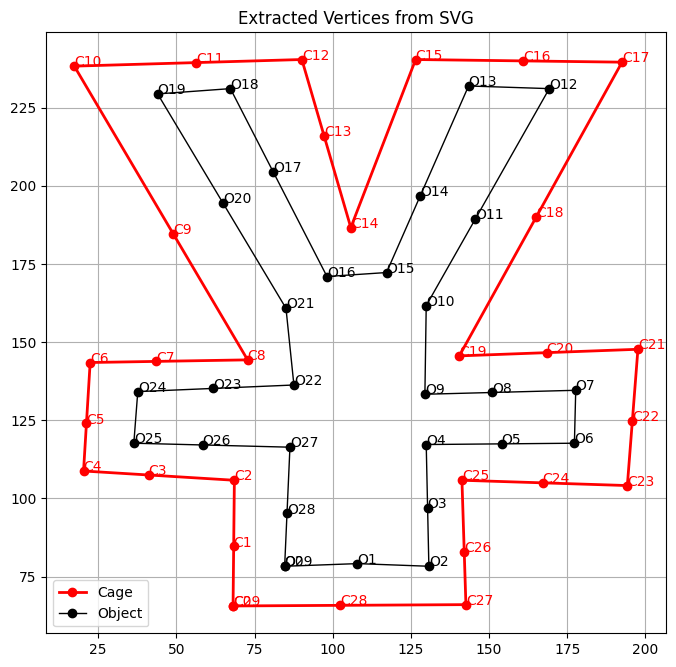

In [74]:
# ---- Plotting Function ----
def plot_svg_geometry(V_cb, E_cb, V_ob, E_ob):
    fig, ax = plt.subplots(figsize=(8, 8))

    if V_cb.size > 0:
        ax.plot(*V_cb.T, 'ro-', label='Cage', linewidth=2)
        for i, (x, y) in enumerate(V_cb):
            ax.text(x, y, f'C{i}', color='red')

    if V_ob.size > 0:
        ax.plot(*V_ob.T, 'ko-', label='Object', linewidth=1)
        for i, (x, y) in enumerate(V_ob):
            ax.text(x, y, f'O{i}', color='black')

    ax.set_aspect('equal')
    ax.legend()
    ax.set_title("Extracted Vertices from SVG")
    ax.grid(True)
    plt.show()



# ---- Example Usage ----
svg_path = "FinalProject/data/gingerbread3.svg"  # Replace with your file
V_cb, E_cb, V_ob, E_ob = extract_svg_geometry_by_id(svg_path)
plot_svg_geometry(V_cb, E_cb, V_ob, E_ob)

In [75]:
import numpy as np
import triangle as tr

assert np.all(E_ob[:, 0] >= 0) and np.all(E_ob[:, 1] < len(V_ob)), "Invalid edge indices"

STEP 2: Define the cage and triangulate

STEP 4: Deform the cage and apply the deformation

In [76]:
'Compute the cage mesh' 

t = tr.triangulate(dict(vertices=V_cb, segments=E_cb) )
print(t.keys())

V_cm = t['vertices']     # Nx2 array of 2D vertex coordinates
F_cm = t['triangles']    # Mx3 array of triangle indices





dict_keys(['vertices', 'vertex_markers', 'triangles'])


NameError: name 'b' is not defined

SyntaxError: incomplete input (4155725690.py, line 32)